In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
#import shap
#shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
train_data = pd.read_csv('../data/train.csv')
train_data = train_data.drop(columns=['Unnamed: 0','City'])
dev_data = pd.read_csv('../data/dev.csv')
dev_data = dev_data.drop(columns=['Unnamed: 0','City'])
test_data = pd.read_csv('../data/test.csv')
test_data = test_data.drop(columns=['Unnamed: 0','City'])

In [49]:
# train

# Encoding categorical features
categorical_features = train_data[['Day','Room.Type','Shared.Room','Private.Room','Superhost']]
categorical_features_one_hot = pd.get_dummies(categorical_features)
# Save transformed dataframe for future use¶
numerical_features =  train_data[['Price',
       'Person.Capacity', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 'Attraction.Index',
       'Normalised.Attraction.Index', 'Restraunt.Index',
       'Normalised.Restraunt.Index']]
y_train = np.log(numerical_features.Price)
numerical_features = numerical_features.drop(['Price'], axis=1)
X_train = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_train_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

# test

# Encoding categorical features
categorical_features = test_data[['Day','Room.Type','Shared.Room','Private.Room','Superhost']]
categorical_features_one_hot = pd.get_dummies(categorical_features)
# Save transformed dataframe for future use¶
numerical_features =  test_data[['Price',
       'Person.Capacity', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 'Attraction.Index',
       'Normalised.Attraction.Index', 'Restraunt.Index',
       'Normalised.Restraunt.Index']]
y_test = np.log(numerical_features.Price)
numerical_features = numerical_features.drop(['Price'], axis=1)
X_test = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_test_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)



In [9]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (29672, 20)
Dimensions of the training target vector: (29672,)
Dimensions of the test feature matrix: (6027, 20)
Dimensions of the test target vector: (6027,)


In [10]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
# Cross-validation
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [12]:
# Scoring basic models (no parameter tuning)

for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.29390 +/- 0.163173
Ridge: 0.29373 +/- 0.163038
Lasso: 0.33125 +/- 0.110569
ElasticNet: 0.33125 +/- 0.110569
RandomForestRegressor: 0.34522 +/- 0.244659
XGBRegressor: 0.49310 +/- 0.440826
HuberRegressor: 0.30084 +/- 0.149088


### linear regression

In [65]:
lr_CV_baseline = -rmse_cv(LinearRegression())
lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train) 
y_train_lr = lr_baseline.predict(X_train)
y_test_lr = lr_baseline.predict(X_test)
lr_baseline_results = pd.DataFrame({'algorithm':['Linear Regression [baseline]'],
            'CV error': lr_CV_baseline.mean(), 
            'CV std': lr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_lr, y_train)],
            'test error': [mean_squared_error(y_test_lr, y_test)]})
lr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Linear Regression [baseline],0.293764,0.16309,0.200571,0.205357


### Linear Regreesion using L2(Ridge) Ridge Regression

In [66]:
lrl2_CV_baseline = -rmse_cv(Ridge(alpha=0.1))
lr_l2 = Ridge(alpha=0.1)
lr_l2.fit(X_train, y_train) 
y_train_lrl2 = lr_l2.predict(X_train)
y_test_lrl2 = lr_l2.predict(X_test)
lrl2_baseline_results = pd.DataFrame({'algorithm':['Linear Regression with L2'],
            'CV error': lrl2_CV_baseline.mean(), 
            'CV std': lrl2_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_lrl2, y_train)],
            'test error': [mean_squared_error(y_test_lrl2, y_test)]})
lrl2_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Linear Regression with L2,0.293763,0.163089,0.200571,0.205357


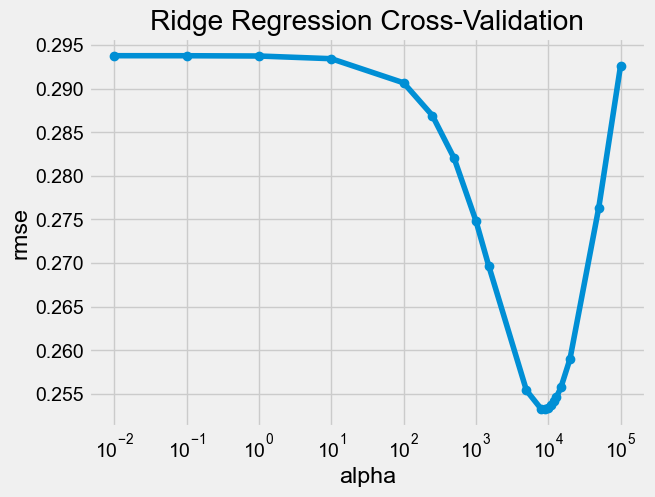

In [21]:
alphas1 = [0.01,0.1,1,10,100,250,500,1000,1500,5000,8000,9000,10000,11000,12000,13000,15000,20000,50000,100000] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 

fig, axes = plt.subplots()
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

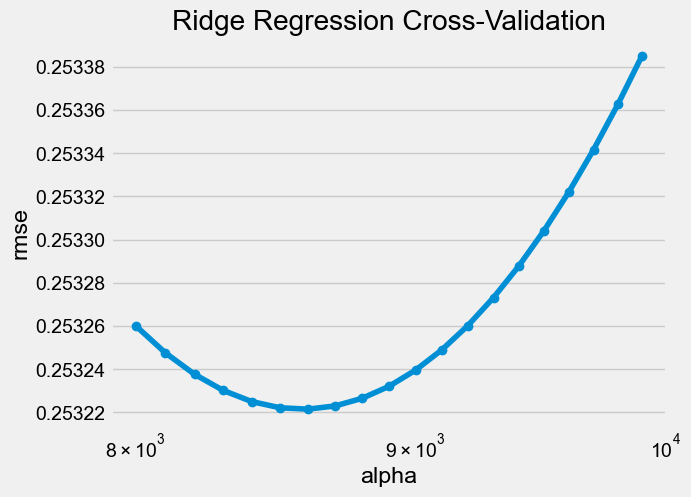

In [27]:
alphas2 = [i for i in range(8000,10000,100)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots()
cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

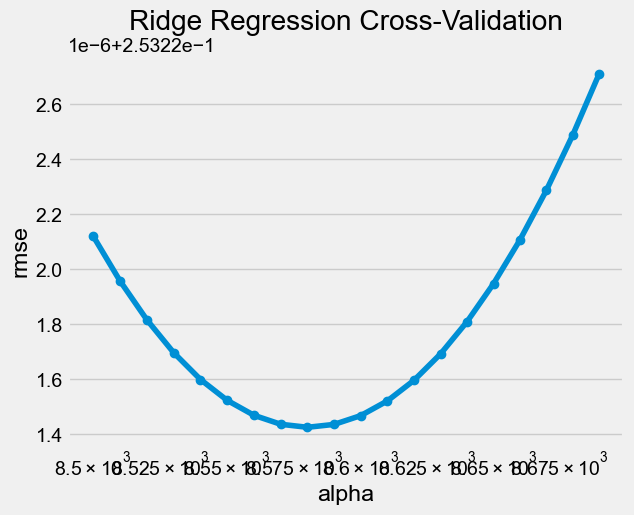

In [30]:
alphas3 = [i for i in range(8500,8700,10)]
cv_ridge3 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas3]
cv_ridge3 = pd.Series(cv_ridge3, index = alphas3) 

fig, axes = plt.subplots()
cv_ridge3.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

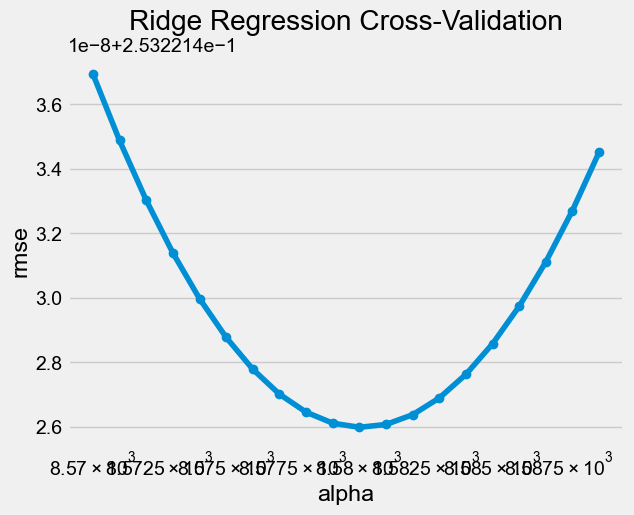

In [34]:
alphas4 = [i for i in range(8570,8590,1)]
cv_ridge4 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas4]
cv_ridge4 = pd.Series(cv_ridge4, index = alphas4) 

fig, axes = plt.subplots()
cv_ridge4.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

In [36]:
# Best Ridge Regression mode
best_alpha = alphas4[np.argmin(cv_ridge4.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.25324,0.105059,0.215299,0.0,0.334586,0.348582


### Linear Regreesion using L1(LASSO) LASSO Regression

In [67]:
lrl1_CV_baseline = -rmse_cv(Lasso(alpha=0.1))
lr_l1 = Lasso(alpha=0.1)
lr_l1.fit(X_train, y_train) 
y_train_lrl1 = lr_l1.predict(X_train)
y_test_lrl1 = lr_l1.predict(X_test)
lrl1_baseline_results = pd.DataFrame({'algorithm':['Linear Regression with L1'],
            'CV error': lrl1_CV_baseline.mean(), 
            'CV std': lrl1_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_lrl1, y_train)],
            'test error': [mean_squared_error(y_test_lrl1, y_test)]})
lrl1_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Linear Regression with L1,0.290331,0.134295,0.231511,0.238319


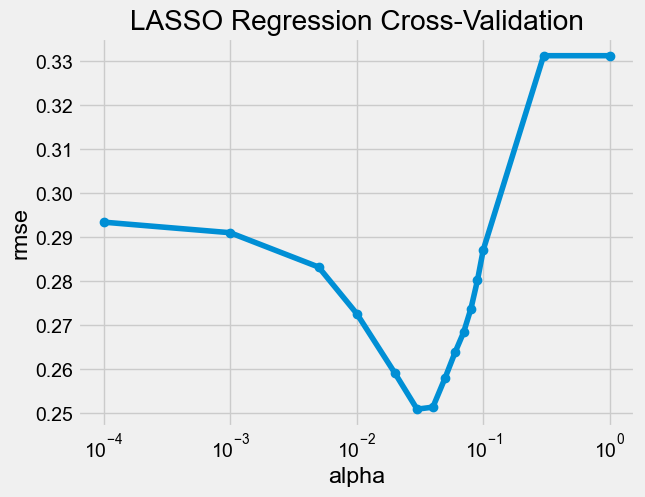

In [40]:
# Hyperparameter optimization
alphas = [0.0001, 0.001, 0.005,0.01,0.02,0.03,0.04, 0.05,0.06, 0.07,0.08,0.09, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-o') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [41]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.250959,0.108304,0.216893,0.224156,0.329657,0.34621


In [42]:
# Variables selected
features = list(categorical_features_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 15 variables


In [43]:
coef

Shared.Room                    0.084721
Private.Room                  -0.000000
Superhost                      0.000000
Day_Weekday                    0.000000
Day_Weekend                    0.000000
Room.Type_Entire home/apt      0.115320
Room.Type_Private room         0.000000
Room.Type_Shared room          0.000000
Person.Capacity                0.000000
Multiple.Rooms                 0.233081
Business                       0.000000
Cleanliness.Rating             0.063762
Guest.Satisfaction            -0.000000
Bedrooms                      -0.000000
City.Center..km.              -0.000000
Metro.Distance..km.           -0.000000
Attraction.Index               0.000000
Normalised.Attraction.Index    0.124546
Restraunt.Index               -0.000000
Normalised.Restraunt.Index    -0.000000
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

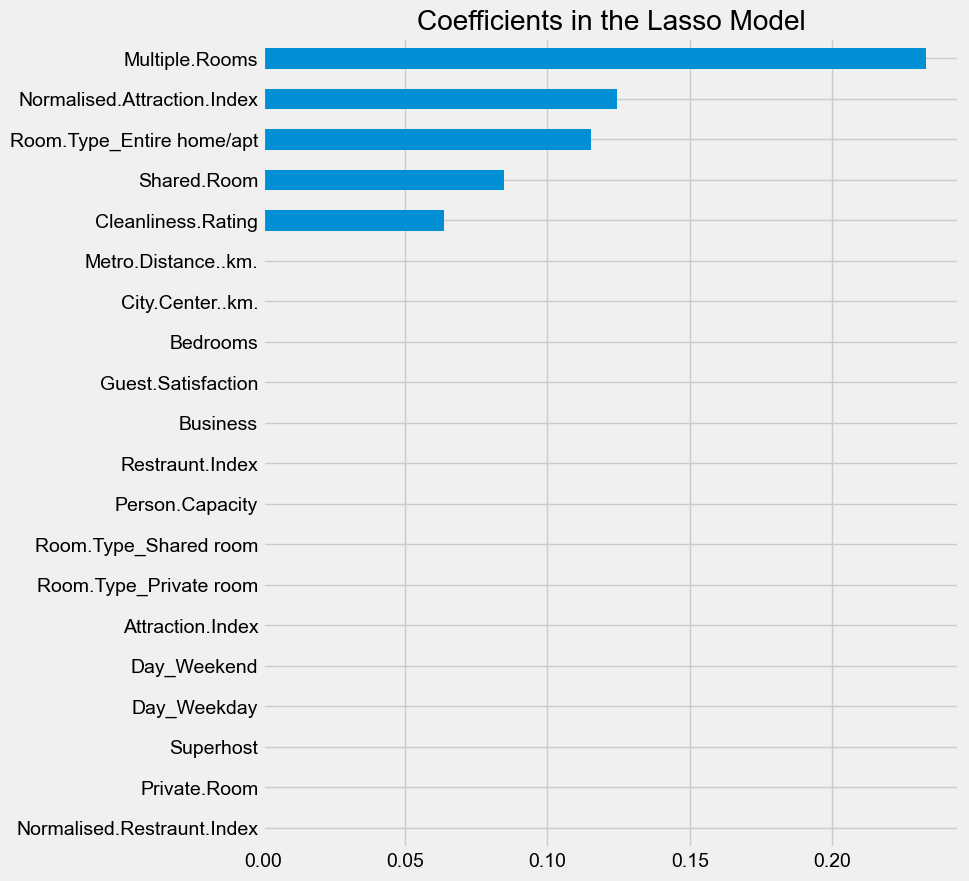

In [44]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-10:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

#### Ridge with variables selected by LASSO

In [50]:
lasso_coef = coef[coef!=0]
Xlv_train = X_train_df[list(lasso_coef.index)]
Xlv_test = X_test_df[list(lasso_coef.index)]

#X_lasso_vars.shape
print('Dimensions of the training feature matrix for lasso variable selection: {}'.format(Xlv_train.shape))
print('Dimensions of the test feature matrix for lasso variable selection: {}'.format(Xlv_test.shape))

Dimensions of the training feature matrix for lasso variable selection: (29672, 5)
Dimensions of the test feature matrix for lasso variable selection: (6027, 5)


In [51]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_lv_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.29376 +/- 0.163090
Ridge: 0.29376 +/- 0.163084
Lasso: 0.29797 +/- 0.085367
ElasticNet: 0.30040 +/- 0.091499
RandomForestRegressor: 0.33495 +/- 0.233748
XGBRegressor: 0.51267 +/- 0.475998


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

HuberRegressor: 0.43692 +/- 0.172285


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



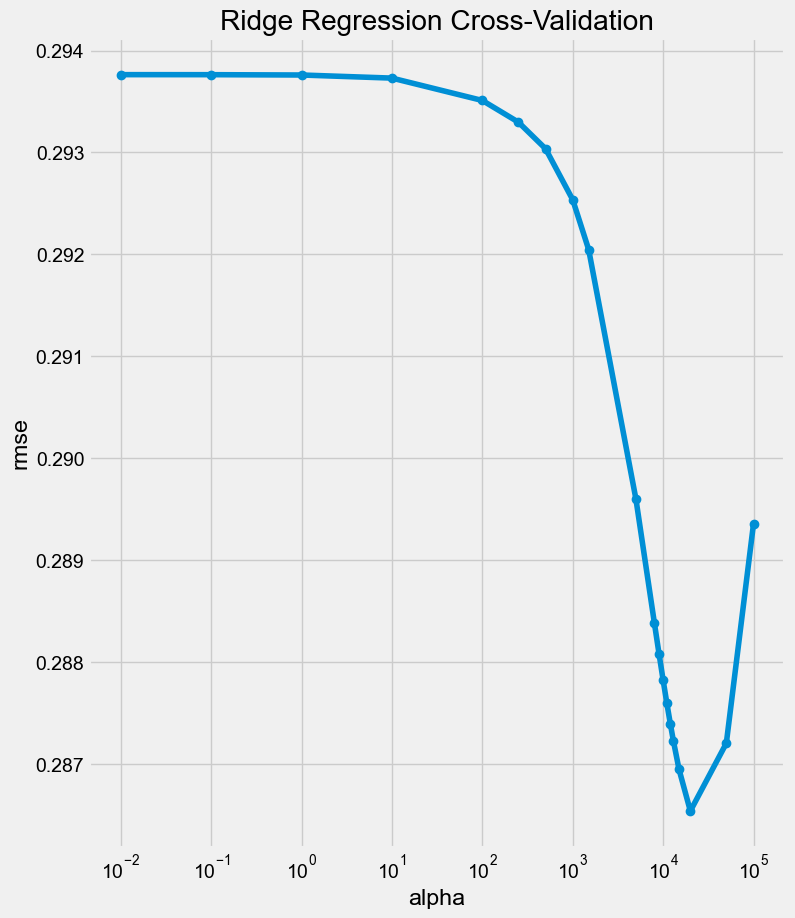

In [55]:
alphas1 = [0.01,0.1,1,10,100,250,500,1000,1500,5000,8000,9000,10000,11000,12000,13000,15000,20000,50000,100000] 
cv_ridge1 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 

fig, axes = plt.subplots()
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

In [59]:
alphas2

[20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000]

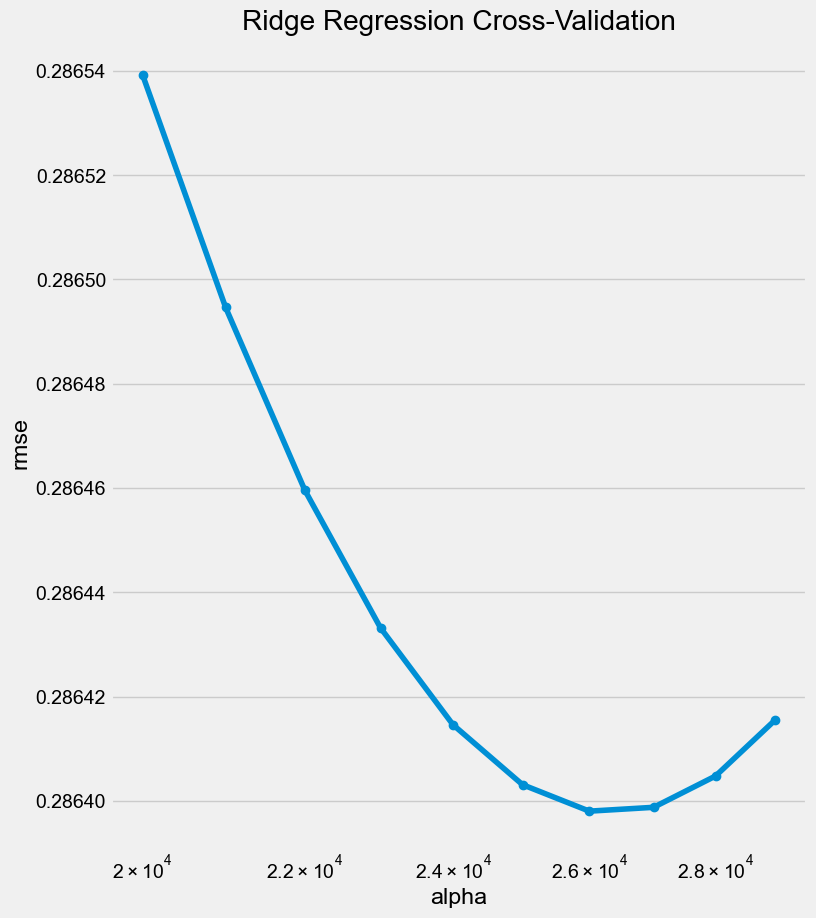

In [58]:
alphas2 = [i for i in range(20000,30000,1000)]
cv_ridge2 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots()
cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

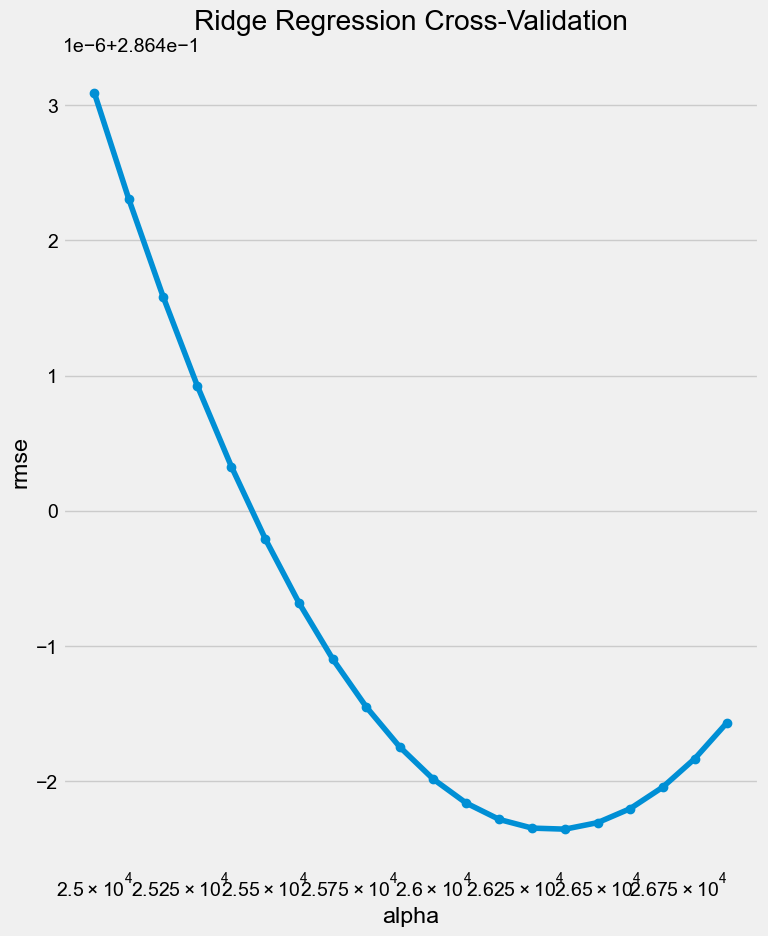

In [60]:
alphas3 = [i for i in range(25000,27000,100)]
cv_ridge3 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas3]
cv_ridge3 = pd.Series(cv_ridge3, index = alphas3) 

fig, axes = plt.subplots()
cv_ridge3.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

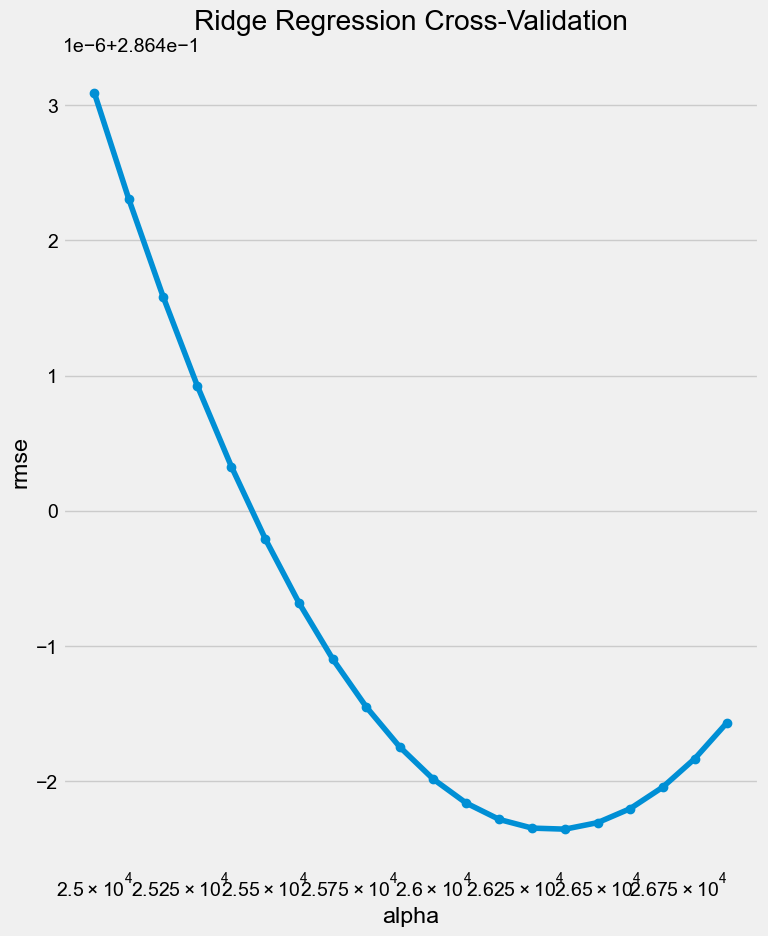

In [62]:
alphas4 = [i for i in range(26300,26500,1)]
cv_ridge4 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas4]
cv_ridge4 = pd.Series(cv_ridge4, index = alphas4) 

fig, axes = plt.subplots()
cv_ridge3.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

In [63]:
best_alpha = alphas4[np.argmin(cv_ridge4.values)]
RR_lassoVars_CV_best = -rmse_lv_cv(Ridge(alpha = best_alpha))
RR_lassoVars = Ridge(alpha = best_alpha) 
RR_lassoVars.fit(Xlv_train, y_train) 
y_train_RR_lassoVars = RR_lassoVars.predict(Xlv_train)
y_test_RR_lassoVars = RR_lassoVars.predict(Xlv_test)
ridge_lassoVars_results = pd.DataFrame({'algorithm':['Ridge Regression with LASSO variable selection'],
            'CV error': RR_lassoVars_CV_best.mean(), 
            'CV std': RR_lassoVars_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR_lassoVars)],
            'test error': [mean_squared_error(y_test, y_test_RR_lassoVars)],
            'training_r2_score': [r2_score(y_train, y_train_RR_lassoVars)],
            'test_r2_score': [r2_score(y_test, y_test_RR_lassoVars)]})

In [64]:
ridge_lassoVars_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression with LASSO variable selection,0.286398,0.146694,0.249079,0.259752,0.230182,0.242387
